## コーパス

In [1]:
# 文章を単語に分割する
text = "You say goodbye and I say hello."
text = text.lower()
text = text.replace('.', ' .')
words = text.split(' ')
print(words)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [2]:
# 単語にIDを振る
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id) # 0, 1, 2, ...
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [3]:
# 単語のリストを単語IDのリストに変換する
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [4]:
# 処理をまとめる
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id) # 0, 1, 2, ...
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [5]:
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6 7]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '': 6, '.': 7}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '', 7: '.'}


## 共起行列

In [6]:
from utills import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [8]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps) # xの正規化
    ny = y / np.sqrt(np.sum(y**2) + eps) # yの正規化
    return np.dot(nx, ny)

In [9]:
C = create_co_matrix(corpus, len(word_to_id))
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [10]:
np.sum(C, axis=0)

array([1, 4, 2, 2, 2, 2, 1])

In [11]:
cos_similarity(C[word_to_id['you']], C[word_to_id['i']])

0.7071067758832467

In [12]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 1. クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. コサイン類似度の算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 3. コサイン類似度の結果から、その値を高い順に出力
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

In [13]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


## PPMI

In [14]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    
    return M

In [13]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
        
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    
    return one_hot

## word2vec：CBOW

CBOW：コンテキストからターゲットを予測するモデル　例：「私は[　]を食べる」の[カレー]を予測する  
Skip-gram：ターゲットからコンテキストを予測するモデル　例：[カレー]から「私は[　]を食べる」を予測する

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary

device = torch.device('cpu')

In [19]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # (1, 7)
W = np.random.randn(7, 3) # (7, 3)
h = np.dot(c, W) # (1, 7)x(7, 3) = (1, 3)

print(h)

[[ 0.33224865  0.56697273 -0.45356309]]


In [3]:
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

In [7]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Linear(vocab_size, hidden_size, bias=False)
        self.out_layer = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, contexts):
        # contexts: (batch_size, window_size*2, vocab_size)
        h = torch.zeros(contexts.size(0), self.hidden_size) # (batch_size, hidden_size)
        for i in range(self.window_size*2):
            h += self.in_layer(contexts[:, i, :])
        h /= self.window_size*2 # 平均を取る
        out = self.out_layer(h) # (batch_size, vocab_size)
        return out

In [8]:
cbow = CBOW(7, 3).to(device)
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])
c2 = np.array([[0, 0, 0, 0, 0, 1, 0]])
c3 = np.array([[0, 1, 0, 0, 0, 0, 0]])
C1 = np.array([c0, c1])
C2 = np.array([c2, c3])
C = np.array([C1, C2])
C = torch.tensor(C, dtype=torch.float32).to(device)
C = C.view(-1, 2, 7)

print(C.shape)

h = cbow(C)
print(h)

torch.Size([2, 2, 7])
tensor([[ 0.0043, -0.0468, -0.0348,  0.0580, -0.0608, -0.0202,  0.0303],
        [ 0.0633, -0.0432,  0.0186,  0.0801, -0.0777, -0.0477,  0.1536]],
       grad_fn=<MmBackward0>)


In [9]:
from utills import preprocess, create_co_matrix

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts = []
target = []

for i in range(1, len(corpus)-1):
    target.append(corpus[i])
    contexts.append([corpus[i-1], corpus[i+1]])


[[0, 2], [1, 3], [2, 4], [3, 1], [4, 5], [1, 6]]

In [11]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [14]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
        
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    
    return one_hot

contexts = convert_one_hot(contexts, len(word_to_id))
target = convert_one_hot(target, len(word_to_id))

In [19]:
contexts = torch.tensor(contexts, dtype=torch.float32).to(device)
target = torch.tensor(target, dtype=torch.float32).to(device)

In [46]:
lr = 0.1
epochs = 1000
batch_size = 3
cbow = CBOW(len(word_to_id), 3).to(device)
optimizer = torch.optim.Adam(cbow.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
hist_loss = []

dataset = torch.utils.data.TensorDataset(contexts, target)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        out = cbow(x)
        loss = loss_fn(out, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    hist_loss.append(total_loss)
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss))

Epoch: 1, Loss: 3.8746
Epoch: 2, Loss: 3.5888
Epoch: 3, Loss: 3.2485
Epoch: 4, Loss: 2.7568
Epoch: 5, Loss: 2.2844
Epoch: 6, Loss: 1.9327
Epoch: 7, Loss: 1.6298
Epoch: 8, Loss: 1.4773
Epoch: 9, Loss: 1.3244
Epoch: 10, Loss: 1.2105
Epoch: 11, Loss: 1.1218
Epoch: 12, Loss: 1.0907
Epoch: 13, Loss: 1.0384
Epoch: 14, Loss: 0.9674
Epoch: 15, Loss: 0.9015
Epoch: 16, Loss: 0.8679
Epoch: 17, Loss: 0.7714
Epoch: 18, Loss: 0.7568
Epoch: 19, Loss: 0.6910
Epoch: 20, Loss: 0.6448
Epoch: 21, Loss: 0.5805
Epoch: 22, Loss: 0.5431
Epoch: 23, Loss: 0.5707
Epoch: 24, Loss: 0.5554
Epoch: 25, Loss: 0.5486
Epoch: 26, Loss: 0.4923
Epoch: 27, Loss: 0.4834
Epoch: 28, Loss: 0.4897
Epoch: 29, Loss: 0.4760
Epoch: 30, Loss: 0.5093
Epoch: 31, Loss: 0.5046
Epoch: 32, Loss: 0.4986
Epoch: 33, Loss: 0.4711
Epoch: 34, Loss: 0.4933
Epoch: 35, Loss: 0.4947
Epoch: 36, Loss: 0.4913
Epoch: 37, Loss: 0.4930
Epoch: 38, Loss: 0.4878
Epoch: 39, Loss: 0.4689
Epoch: 40, Loss: 0.4920
Epoch: 41, Loss: 0.4891
Epoch: 42, Loss: 0.4947
E

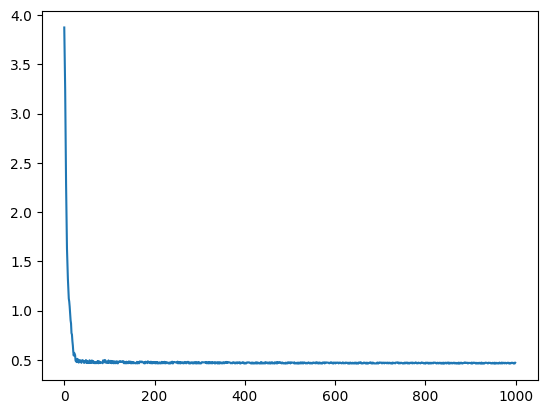

In [47]:
import matplotlib.pyplot as plt

plt.plot(hist_loss)
plt.show()

In [48]:
cbow.eval()

h = cbow(contexts)
h = nn.Softmax(dim=1)(h)
ids = torch.argmax(h, dim=1)
print(ids)
target_ids = torch.argmax(target, dim=1)
print(target_ids)

tensor([1, 4, 3, 4, 1, 5])
tensor([1, 2, 3, 4, 1, 5])


## word2vec：Skip-gram

In [49]:
class Skip_gram(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Linear(vocab_size, hidden_size, bias=False)
        self.out_layers = nn.ModuleList([nn.Linear(hidden_size, vocab_size, bias=False) for _ in range(window_size*2)])

    def forward(self, x):
        h = self.in_layer(x)
        outs = torch.zeros(self.window_size*2, x.size(0), self.vocab_size).to(device)

        for i in range(self.window_size*2):
            outs[i] = self.out_layers[i](h)
        
        outs = outs.permute(1, 0, 2)
        return outs

In [111]:
from utills import preprocess, create_co_matrix

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts = []
target = []

contexts, target = create_contexts_target(corpus, window_size=1)

contexts = convert_one_hot(contexts, len(word_to_id))
target = convert_one_hot(target, len(word_to_id))

contexts = torch.tensor(contexts, dtype=torch.float32).to(device)
target = torch.tensor(target, dtype=torch.float32).to(device)

In [112]:
skg = Skip_gram(len(word_to_id), 3).to(device)
h = skg(target)
h

tensor([[[-3.2925e-03,  1.5181e-01, -6.9794e-03,  1.4278e-01,  2.4935e-02,
           8.5825e-02,  2.9294e-02],
         [ 1.1800e-01,  9.6726e-02,  1.4390e-01,  2.5298e-01, -2.1166e-01,
          -8.4658e-02,  4.0979e-02]],

        [[-2.8242e-01,  8.4313e-02,  3.1755e-01,  6.6480e-02,  1.9356e-02,
          -2.0018e-01, -3.0315e-01],
         [-1.2399e-01,  2.4902e-01,  2.3009e-01,  2.1007e-01, -1.9345e-01,
           7.4020e-03,  1.5996e-01]],

        [[ 8.6090e-03,  7.7049e-04, -6.8649e-02,  6.8159e-02,  8.3572e-02,
           6.2565e-02,  1.1617e-02],
         [-5.3538e-02, -8.4568e-02, -6.4010e-02,  1.1171e-02, -2.5755e-02,
          -1.5471e-02, -1.2162e-01]],

        [[-1.4617e-04, -2.4230e-02, -7.8610e-02,  6.9059e-02,  1.1063e-01,
           6.0415e-02, -3.1801e-03],
         [-1.0147e-01, -1.2332e-01, -1.0501e-01, -2.3731e-02, -3.4211e-03,
          -4.6793e-03, -1.6739e-01]],

        [[-3.2925e-03,  1.5181e-01, -6.9794e-03,  1.4278e-01,  2.4935e-02,
           8.5825e-02

In [113]:
h = nn.Softmax(dim=2)(h)
h

tensor([[[0.1338, 0.1562, 0.1333, 0.1548, 0.1376, 0.1462, 0.1382],
         [0.1513, 0.1481, 0.1552, 0.1731, 0.1088, 0.1235, 0.1400]],

        [[0.1099, 0.1586, 0.2002, 0.1558, 0.1486, 0.1193, 0.1076],
         [0.1153, 0.1674, 0.1642, 0.1610, 0.1075, 0.1315, 0.1531]],

        [[0.1405, 0.1394, 0.1301, 0.1492, 0.1515, 0.1483, 0.1410],
         [0.1423, 0.1380, 0.1408, 0.1518, 0.1463, 0.1478, 0.1329]],

        [[0.1399, 0.1366, 0.1293, 0.1499, 0.1563, 0.1486, 0.1395],
         [0.1390, 0.1360, 0.1385, 0.1502, 0.1533, 0.1531, 0.1301]],

        [[0.1338, 0.1562, 0.1333, 0.1548, 0.1376, 0.1462, 0.1382],
         [0.1513, 0.1481, 0.1552, 0.1731, 0.1088, 0.1235, 0.1400]],

        [[0.1348, 0.1528, 0.1694, 0.1415, 0.1349, 0.1320, 0.1345],
         [0.1375, 0.1552, 0.1524, 0.1428, 0.1241, 0.1318, 0.1563]]],
       grad_fn=<SoftmaxBackward0>)

In [61]:
torch.sum(torch.log(h[0]) * contexts[0], dim=1)

tensor([-1.9374, -1.9709], grad_fn=<SumBackward1>)

In [79]:
torch.sum(torch.log(h) * contexts, dim=2)

tensor([[-1.8034, -2.0998],
        [-1.8444, -1.9928],
        [-2.2531, -1.8134],
        [-2.0392, -1.7114],
        [-2.0461, -1.8309],
        [-1.7763, -1.8358]], grad_fn=<SumBackward1>)

In [83]:
def loss_func(out, contexts):
    out = nn.Softmax(dim=2)(out)
    loss = torch.sum(torch.log(out) * contexts, dim=2)
    loss = torch.sum(loss, dim=1)
    loss = -torch.mean(loss)
    return loss

In [85]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts = []
target = []

contexts, target = create_contexts_target(corpus, window_size=1)

contexts = convert_one_hot(contexts, len(word_to_id))
target = convert_one_hot(target, len(word_to_id))

contexts = torch.tensor(contexts, dtype=torch.float32).to(device)
target = torch.tensor(target, dtype=torch.float32).to(device)

In [90]:
def loss_func(out, contexts):
    out = nn.Softmax(dim=2)(out)
    loss = torch.sum(torch.log(out) * contexts, dim=2)
    loss = torch.sum(loss, dim=1)
    loss = -torch.mean(loss)
    return loss

dataset = torch.utils.data.TensorDataset(target, contexts)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

lr = 0.01
epochs = 1000
batch_size = 3
skip_gram = Skip_gram(len(word_to_id), 3).to(device)
optimizer = torch.optim.Adam(skip_gram.parameters(), lr=lr)
loss_fn = loss_func

hist_loss = []

for epoch in range(epochs):
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        out = skip_gram(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    hist_loss.append(total_loss)
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss))


Epoch: 1, Loss: 7.6316
Epoch: 2, Loss: 7.5733
Epoch: 3, Loss: 7.5136
Epoch: 4, Loss: 7.4577
Epoch: 5, Loss: 7.3996
Epoch: 6, Loss: 7.3334
Epoch: 7, Loss: 7.2664
Epoch: 8, Loss: 7.1997
Epoch: 9, Loss: 7.1233
Epoch: 10, Loss: 7.0482
Epoch: 11, Loss: 6.9684
Epoch: 12, Loss: 6.8823
Epoch: 13, Loss: 6.7925
Epoch: 14, Loss: 6.6986
Epoch: 15, Loss: 6.5969
Epoch: 16, Loss: 6.4965
Epoch: 17, Loss: 6.3911
Epoch: 18, Loss: 6.2766
Epoch: 19, Loss: 6.1650
Epoch: 20, Loss: 6.0428
Epoch: 21, Loss: 5.9202
Epoch: 22, Loss: 5.7929
Epoch: 23, Loss: 5.6680
Epoch: 24, Loss: 5.5396
Epoch: 25, Loss: 5.4061
Epoch: 26, Loss: 5.2706
Epoch: 27, Loss: 5.1345
Epoch: 28, Loss: 4.9978
Epoch: 29, Loss: 4.8578
Epoch: 30, Loss: 4.7174
Epoch: 31, Loss: 4.5791
Epoch: 32, Loss: 4.4437
Epoch: 33, Loss: 4.3043
Epoch: 34, Loss: 4.1749
Epoch: 35, Loss: 4.0377
Epoch: 36, Loss: 3.9086
Epoch: 37, Loss: 3.7751
Epoch: 38, Loss: 3.6486
Epoch: 39, Loss: 3.5248
Epoch: 40, Loss: 3.4049
Epoch: 41, Loss: 3.2866
Epoch: 42, Loss: 3.1779
E

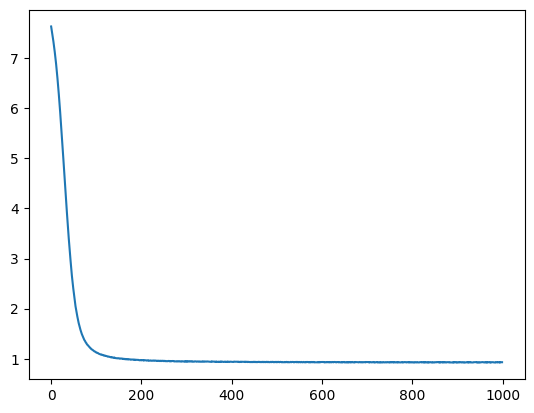

In [91]:
import matplotlib.pyplot as plt

plt.plot(hist_loss)
plt.show()

In [123]:
skip_gram.eval()

h = skip_gram(target)
h = nn.Softmax(dim=2)(h)
ids = torch.argmax(h, dim=2)
print(ids)
contexts_ids = torch.argmax(contexts, dim=2)
print(contexts_ids)

tensor([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [0, 2],
        [1, 6]])
tensor([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [4, 5],
        [1, 6]])


## Embeddingレイヤの使用

In [4]:
import numpy as np
import torch
import torch.nn as nn
from utills import *

device = torch.device('cpu')

In [45]:
class CBOW_embedding(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Embedding(vocab_size, hidden_size) # #mbedding層
        self.out_layer = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, contexts):
        # contexts: (batch_size, window_size*2)
        h = self.in_layer(contexts) # (batch_size, window_size*2, hidden_size)
        h = torch.mean(h, dim=1) # (batch_size, hidden_size)
        # out = self.out_layer(h) # (batch_size, vocab_size)
        return h

In [46]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [47]:
cbow = CBOW_embedding(len(word_to_id), 3).to(device)

In [48]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [49]:
contexts = torch.tensor(contexts, dtype=torch.long).to(device)
target = torch.tensor(target, dtype=torch.long).to(device)

In [50]:
cbow(contexts)

tensor([[-0.0035, -0.7420,  0.3500],
        [ 0.8095, -0.4387, -0.8171],
        [-0.5953, -0.4957, -0.9881],
        [ 0.8095, -0.4387, -0.8171],
        [-0.1139, -0.3172, -0.8481],
        [ 0.2144, -0.7447,  0.4828]], grad_fn=<MeanBackward1>)

In [31]:
class CBOW_embedding_negative(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Embedding(vocab_size, hidden_size) # embedding層: (vocab_size, hidden_size)
        self.out_layer = nn.Embedding(vocab_size, hidden_size) # embedding層: (vocab_size, hidden_size)

    def forward(self, contexts, positive, negative):
        # contexts: (batch_size, window_size*2)
        h = self.in_layer(contexts) # (batch_size, window_size*2, hidden_size)
        h = torch.mean(h, dim=1) # (batch_size, hidden_size)
        out_positive = self.out_layer(positive) # (batch_size, hidden_size)
        out_negative = self.out_layer(negative) # (batch_size, negative_size, hidden_size)

        out_positive = torch.sum(h * out_positive, dim=1) # (batch_size): 内積
        out_negative = torch.sum(h.unsqueeze(1) * out_negative, dim=2) # (batch_size, negative_size): 内積
        return out_positive, out_negative
    
    def get_embedding(self):
        return self.in_layer.weight.data.cpu().numpy()

In [63]:
t1 = torch.tensor([[1, 2, 3], [4, 5, 6]]).to(device)
t2 = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[1, 2, 3], [4, 5, 6]]]).to(device)

torch.sum(t1 * t2, dim=2)

tensor([[14, 77],
        [14, 77]])

In [7]:
class negative_sampling:
    def __init__(self, corpus, power=0.75, sample_size=5):
        self.corpus = corpus # 単語IDのリスト
        self.power = power
        self.sample_size = sample_size

        self.idx, self.count = np.unique(corpus, return_counts=True) # 単語の出現回数
        self.p = self.count / np.sum(self.count) # 単語の出現確率
        self.p = self.p ** self.power / np.sum(self.p ** self.power) # 負例の確率分布
    
    def get_negative_sample(self, target):
        batsch_size = len(target)
        negative_sample = np.zeros((batsch_size, self.sample_size), dtype=np.int32)
        for i in range(batsch_size):
            p = self.p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.idx, size=self.sample_size, replace=False, p=p)
        return negative_sample



In [9]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)
negative_sampler = negative_sampling(corpus)
negative_sample = negative_sampler.get_negative_sample(target)

contexts = torch.tensor(contexts, dtype=torch.long).to(device)
target = torch.tensor(target, dtype=torch.long).to(device)
negative = torch.tensor(negative_sample, dtype=torch.long).to(device)
positive = torch.tensor(target, dtype=torch.long).to(device)

C:\Users\daiki\AppData\Local\Temp\ipykernel_23492\2473442462.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive = torch.tensor(target, dtype=torch.long).to(device)


In [11]:
cbow = CBOW_embedding_negative(len(word_to_id), 3).to(device)

out_positive, out_negative = cbow(contexts, positive, negative)

In [14]:
torch.sum(torch.sigmoid(out_negative))

tensor(15.6938, grad_fn=<SumBackward0>)

In [21]:
def loss_func(out_positive, out_negative):
    out_positive = torch.sigmoid(out_positive) # (batch_size)
    out_negative = torch.sigmoid(out_negative) # (batch_size, sample_size)
    loss = -torch.sum(torch.log(out_positive)) - torch.sum(torch.log(1 - out_negative), dim=1)
    loss = torch.mean(loss)
    return loss

In [32]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)
negative_sampler = negative_sampling(corpus)
negative_sample = negative_sampler.get_negative_sample(target)

contexts = torch.tensor(contexts, dtype=torch.long).to(device)
positive = torch.tensor(target, dtype=torch.long).to(device)

cbow = CBOW_embedding_negative(len(word_to_id), 3).to(device)
lr = 0.05
epochs = 1000
batch_size = 3
optimizer = torch.optim.Adam(cbow.parameters(), lr=lr)
loss_fn = loss_func

dataset = torch.utils.data.TensorDataset(contexts, positive)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

hist_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (contexts, positive) in enumerate(loader):
        negative_sample = negative_sampler.get_negative_sample(positive)
        negative = torch.tensor(negative_sample, dtype=torch.long).to(device)

        optimizer.zero_grad()
        out_positive, out_negative = cbow(contexts, positive, negative)
        loss = loss_fn(out_positive, out_negative)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    hist_loss.append(running_loss)
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1}, loss: {running_loss:.2f}')

epoch: 100, loss: 1.81
epoch: 200, loss: 1.53
epoch: 300, loss: 1.58
epoch: 400, loss: 1.52
epoch: 500, loss: 1.53
epoch: 600, loss: 1.53
epoch: 700, loss: 0.96
epoch: 800, loss: 0.96
epoch: 900, loss: 1.53
epoch: 1000, loss: 1.52


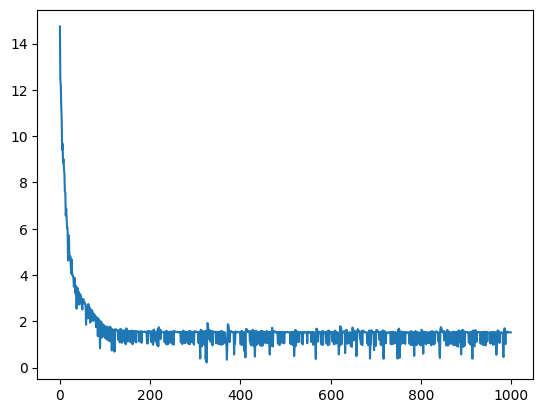

In [33]:
import matplotlib.pyplot as plt

plt.plot(hist_loss)
plt.show()

In [34]:
cbow.get_embedding()

array([[-6.962084  ,  2.8039944 ,  2.9225554 ],
       [ 0.59344816,  3.5227647 , -0.8129722 ],
       [ 1.6782836 ,  2.5621574 ,  3.4552286 ],
       [ 2.0984256 ,  1.7116871 ,  0.31451216],
       [ 0.51081467,  2.900489  ,  4.9556127 ],
       [-5.505786  ,  2.459367  ,  1.1749018 ],
       [-4.999139  ,  5.454779  , -3.112235  ]], dtype=float32)

In [ ]:
class Skip_gram(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Linear(vocab_size, hidden_size, bias=False)
        self.out_layers = nn.ModuleList([nn.Linear(hidden_size, vocab_size, bias=False) for _ in range(window_size*2)])

    def forward(self, x):
        h = self.in_layer(x)
        outs = torch.zeros(self.window_size*2, x.size(0), self.vocab_size).to(device)

        for i in range(self.window_size*2):
            outs[i] = self.out_layers[i](h)
        
        outs = outs.permute(1, 0, 2)
        return outs

In [ ]:
class Skip_gram(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Embedding(vocab_size, hidden_size)
        self.out_layers = nn.ModuleList([nn.Embedding(vocab_size, hidden_size) for _ in range(window_size*2)])

    def forward(self, x, positive, negative):
        h = self.in_layer(x)

In [ ]:
class CBOW_embedding_negative(nn.Module):
    def __init__(self, vocab_size, hidden_size, window_size=1):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.in_layer = nn.Embedding(vocab_size, hidden_size) # embedding層: (vocab_size, hidden_size)
        self.out_layer = nn.Embedding(vocab_size, hidden_size) # embedding層: (vocab_size, hidden_size)

    def forward(self, contexts, positive, negative):
        # contexts: (batch_size, window_size*2)
        h = self.in_layer(contexts) # (batch_size, window_size*2, hidden_size)
        h = torch.mean(h, dim=1) # (batch_size, hidden_size)
        out_positive = self.out_layer(positive) # (batch_size, hidden_size)
        out_negative = self.out_layer(negative) # (batch_size, negative_size, hidden_size)

        out_positive = torch.sum(h * out_positive, dim=1) # (batch_size): 内積
        out_negative = torch.sum(h.unsqueeze(1) * out_negative, dim=2) # (batch_size, negative_size): 内積
        return out_positive, out_negative
    
    def get_embedding(self):
        return self.in_layer.weight.data.cpu().numpy()